In [1]:
import torch
import torchaudio

import numpy as np
import pandas as pd

import os

from scipy.io import wavfile as wav
from functools import lru_cache

from tqdm import tqdm, trange

In [2]:
class Files:
    data_loc = 'data/Calls for ML/'

    # create symlinks so that all the data can be seen from labelled_data
    lb_data_loc = 'data/Calls for ML/labelled_data/'

    state_dict = 'data/Calls for ML/simple_rnn_sd.pth'

    ml_test = 'ML_Test.wav'
    labels_file = 'Calls_ML.xlsx'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

SR = 44100
N_MELS = 40
FEATURIZER = torchaudio.transforms.MFCC(sample_rate=SR, n_mfcc=N_MELS).to(device)
softplus = torch.nn.Softplus()

/Users/rkd/Research/Monke/cmci/venv/lib/python3.9/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [4]:
@lru_cache(maxsize=100)
def load_audio_file(filename):
    sr, audio = wav.read(filename)
    if len(audio.shape) == 2:
        audio = audio[:, 0]  # take the first channel
    audio = audio.astype('f')/1000  # scale values down by 1000.
    return sr, audio

In [5]:
def load_audio(file_path):
    sr, audio = load_audio_file(file_path)
    audio = torchaudio.functional.resample(torch.tensor(audio), sr, SR)
    return audio

In [6]:
def preprocess_call_labels(calls_og, keep_only_conures=True):
    calls = calls_og.copy()
    calls.columns = [c.lower().replace(' ', '_') for c in calls.columns]
    if keep_only_conures:
        calls = calls.loc[~calls.call_type.isna() | (calls.interference == 'Conure')].reset_index(drop=True) #drop conure calls?
    calls.loc[calls.call_type.isna(), 'call_type'] = 'interference' # set all unknown call types to interference
    calls = calls.loc[calls.start < calls.end].reset_index(drop=True)
    calls['call_type'] = calls.call_type.apply(lambda r: r.split(' ')[0])
    return calls

In [7]:
class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, device='cpu'):
        self.audio = {
            f.replace('.wav', ''): load_audio(Files.lb_data_loc + f).to(device) for f in os.listdir(Files.lb_data_loc) if '.wav' in f
        }
        self.audio_lens = {k: (len(a), len(a)/SR) for k, a in self.audio.items()}

        calls = pd.read_excel(os.path.join(Files.lb_data_loc, Files.labels_file))
        calls = preprocess_call_labels(calls, keep_only_conures=False)
        calls = calls.loc[
            (calls.call_type != 'interference'),
            ['file', 'call_type', 'start', 'end']
        ]

        calls_shaldon = pd.read_excel(os.path.join(Files.lb_data_loc, 'Shaldon_Training_Labels.xlsx'))
        calls_shaldon = calls_shaldon.loc[~calls_shaldon.Call_Type.isna(), ['File', 'Call_Type', 'Start', 'End']]
        calls_shaldon['File'] = 'Shaldon_Combined'
        calls_shaldon.columns = calls_shaldon.columns.str.lower()

        calls_blackpool = pd.read_excel(os.path.join(Files.lb_data_loc, 'Blackpool_Labels.xlsx'))
        calls_blackpool = calls_blackpool.loc[~calls_blackpool.Call_Type.isna(), ['File', 'Call_Type', 'Start', 'End']]
        calls_blackpool['File'] = 'Blackpool_Combined_FINAL'
        calls_blackpool.columns = calls_blackpool.columns.str.lower()

        self.labels = pd.concat([calls, calls_shaldon, calls_blackpool], axis=0).reset_index(drop=True)

        # l("Computing mfcc.")
        self.featurizer = FEATURIZER

        # l("Preprocessing label time series.")
        self.nps = self.featurizer(torch.zeros(1, SR).to(device)).shape[-1]

        self.features = {k: self.featurizer(a).T for k, a in self.audio.items()}

        self.label_ts = {k: None for k in self.audio.keys()}
        ts = {k: self.audio_lens[k][-1]*torch.arange(f.shape[0]).to(device)/f.shape[0] for k, f in self.features.items()}
        for k in ts.keys():
            temp_df = np.asarray(self.labels.loc[self.labels.file == k, ['start', 'end']])
            self.label_ts[k] = torch.zeros_like(ts[k])
            for start, end in temp_df:
                self.label_ts[k][(ts[k] >= start) & (ts[k] < end)] = 1.0
        self.ts = ts

    def __len__(self):
        return 1

    def get_samples(self, audio_len=2.5):
        assert audio_len < 5
        segm_len = int(self.nps * audio_len)

        features = []
        labels = []
        zoos = []

        # l('Processing data.')
        files_to_process = [f for f in self.features.keys() if f != 'ML_Test_3']
        for file in files_to_process:
            # l(f'Processing {file}')
            lbs, feats = self.label_ts[file], self.features[file]
            for i in trange(max(0, len(feats)//segm_len)):
                start_idx = i*segm_len # np.random.choice(len(feats) - segm_len - 1)
                end_idx = start_idx + segm_len

                _ft = feats[None, start_idx:end_idx, :].clone()
                _lb = lbs[None, start_idx:end_idx].clone()
                if (len(_ft[0]) == len(_lb[0])) and (len(_lb[0]) == segm_len):
                    features.append(_ft)
                    labels.append(_lb)
                    zoos.append(np.array([file]*segm_len, dtype=str)[None, ...])

        return (torch.cat(features, axis=0), torch.cat(labels, axis=0),
                np.concatenate(zoos, axis=0))

    def __getitem__(self, *args):
        return self.get_samples()

In [8]:
dataset = AudioDataset(device=device)
X_full, y_full, z_full = dataset[...]

100%|██████████| 799/799 [00:00<00:00, 9825.63it/s]


In [9]:
idx = np.random.choice(len(y_full), len(y_full), replace=False)
train_idx, test_idx = idx[:int(0.9*len(idx))], idx[int(0.9*len(idx)):]

X_train = X_full[train_idx, ...]
y_train = y_full[train_idx, ...]

X_test = X_full[test_idx, ...]
y_test = y_full[test_idx, ...].cpu().numpy().reshape(-1)
z_test = z_full[test_idx, ...].reshape(-1)

conv = {'Blackpool_Combined_FINAL': 'blackpool', 'Shaldon_Combined': 'shaldon',
        'ML_Test': 'banham', 'ML_Test_2a': 'banham', 'ML_Test_2b': 'banham'}

for k, repl in conv.items():
    z_test[z_test == k] = repl

X_test_2 = dataset.featurizer(dataset.audio['ML_Test_3']).T[None, ...]
y_test_2 = dataset.label_ts['ML_Test_3'].cpu().numpy()

In [76]:
class Classifier(torch.nn.Module):
    def __init__(self, num_inp, num_lstm=3):
        super().__init__()
        self.num_lstm = num_lstm
        self.lstm = torch.nn.LSTM(num_inp, 16, num_lstm, batch_first=True)
        self.fc = torch.nn.Linear(16, 1)

    def forward(self, x):
        x = (x - x.mean(axis=-1)[..., None]) / (x.std(axis=-1)[..., None] + 1e-9)
        h0 = torch.zeros(self.num_lstm, x.size(0), 16).to(x.device).normal_()*0.01
        c0 = torch.zeros(self.num_lstm, x.size(0), 16).to(x.device).normal_()*0.01

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out).sigmoid()[..., 0]
        return out

In [77]:
classifier = Classifier(N_MELS).to(device)
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)
criterion = torch.nn.BCELoss()

In [78]:
from sklearn.metrics import confusion_matrix

In [79]:
losses = []
iterator = trange(2000, leave=False)
for i in iterator:
    optimizer.zero_grad()
    idx = np.random.choice(len(y_train), 500)
    y_prob = classifier(X_train[idx])
    loss = criterion(y_prob, y_train[idx])
    # loss = -torch.distributions.Bernoulli(probs=y_prob).log_prob(y_train[idx]).sum()
    if i % 100 == 0:
        tr_cm = confusion_matrix(y_train[idx].reshape(-1).cpu(), y_prob.round().reshape(-1).detach().cpu(), normalize='all').round(3)*100
        tr_cm = (tr_cm[0, 0] + tr_cm[1, 1]).round(2)

        pred = classifier(X_test).detach().cpu().round().reshape(-1)
        pred[0] = 0; pred[-1] = 1
        cm = confusion_matrix(y_test, pred, normalize='all').round(3)*100
        cm = (cm[0, 0] + cm[1, 1]).round(2)

        pred_2 = classifier(X_test_2)[0].detach().cpu().numpy()
        cm_2 = confusion_matrix(y_test_2, pred_2.round(), normalize='all').round(3)*100
        cm_2 = (cm_2[0, 0] + cm_2[1, 1]).round(2)

    losses.append(loss.item())
    iterator.set_description(f'L:{np.round(loss.item(), 2)},Tr:{tr_cm},Te:{cm},Te2:{cm_2}')
    # wandb.log(dict(l=loss.item(), tr=tr_cm, te=cm, te_mlt3=cm_2))
    loss.backward()
    optimizer.step()

In [87]:
classifier.eval()
pred = classifier(X_test_2).detach().cpu().round().reshape(-1)

(0.0, 2000.0)

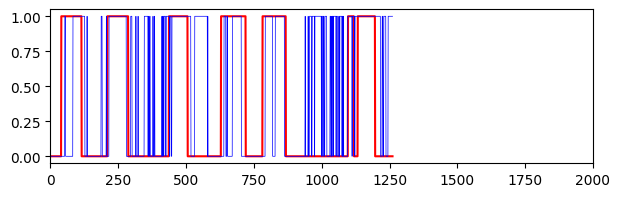

In [89]:
import matplotlib.pyplot as plt

plt.plot(y_test_2, 'r')
plt.plot(pred, 'b', lw=0.5)

plt.xlim(0,2000)

In [85]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('Accuracy:', accuracy_score(y_test, pred))
print('Precision:', precision_score(y_test, pred))
print('Recall:', recall_score(y_test, pred))
print('F1:', f1_score(y_test, pred))

Accuracy: 0.9580583592132506
Precision: 0.910398319463521
Recall: 0.8836260978670013
F1: 0.8968124477695093


In [90]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('Accuracy:', accuracy_score(y_test_2, pred))
print('Precision:', precision_score(y_test_2, pred))
print('Recall:', recall_score(y_test_2, pred))
print('F1:', f1_score(y_test_2, pred))

Accuracy: 0.6719492868462758
Precision: 0.555205047318612
Recall: 0.7272727272727273
F1: 0.629695885509839


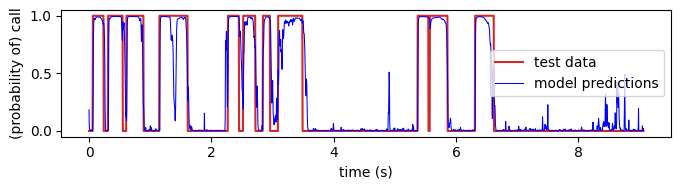

In [86]:
plt.rcParams["figure.figsize"] = (7, 2)
plt.plot(dataset.ts['Blackpool_Combined_FINAL'][:2000].cpu(), dataset.label_ts['Blackpool_Combined_FINAL'][:2000].cpu(), c='tab:red', label='test data')
plt.plot(dataset.ts['Blackpool_Combined_FINAL'][:2000].cpu(), classifier(dataset.features['Blackpool_Combined_FINAL'][None, :2000, :])[0].cpu().detach(), c='b', lw=0.75, label='model predictions')

plt.xlabel('time (s)')
plt.ylabel('(probability of) call')
plt.tight_layout()
plt.legend(loc='center right')